### CPS ASEC replicate Census Median HH Income Estimates

Brian Dew, brian.w.dew@gmail.com

December 28, 2019

----

Try to replicate the median household income statistics [published](https://www.census.gov/library/publications/2018/demo/p60-263.html) by Census, using a binned- and weighted-median.

The number I want to get (at least very close) is $61,372.


Also want to clean up the code a bit.

In [1]:
import os, re, struct
import pandas as pd
import numpy as np

os.chdir('/home/brian/Documents/ASEC/data/')

In [2]:
# read data dictionary text file 
pubuse_file = 'asec2018_pubuse.dat'
dd_file = '08ASEC2018_Data_Dict_Full.txt'
data_dict = open(dd_file, 'r', encoding='iso-8859-1').read()

In [3]:
# Retrieve column info from dictionary
variables = ['HRECORD', 'HSUP_WGT', 'HTOTVAL']
p = re.compile(f'D ({"|".join(variables)})\s+(\d{{1,2}})\s+(\d+)\s+')
cols = {name: (int(start) - 1, int(start) - 1 + int(length)) 
        for name, length, start in re.findall(p, data_dict)}

In [4]:
# Read raw fwf file
df = (pd.read_fwf(pubuse_file, 
                  colspecs=list(cols.values()), 
                  header=None, 
                  names=cols.keys())
        .query('HRECORD == 1 and HSUP_WGT > 0'))

In [3]:
def binned_weighted_percentile(group, percentile=0.5, weight='HSUP_WGT', val_var='HTOTVAL'):
    """Return BLS-styled binned and weighted percentile"""
    bin_size = 2500
    bins = list(np.arange(-30000, 1250000, bin_size))
    # Cut wage series according to bins of bin_size
    bin_cut = lambda x: pd.cut(x[val_var], bins, include_lowest=True)
    
    # Calculate cumulative sum for weight variable
    cum_sum = lambda x: x[weight].cumsum()
    
    # Sort wages then apply bin_cut and cum_sum
    df = (group.sort_values(val_var)
               .assign(WAGE_BIN = bin_cut, CS = cum_sum))
    
    # Find the weight at the percentile of interest
    pct_wgt = df[weight].sum() * percentile

    # Find wage bin for person nearest to weighted percentile
    pct_bin = df.iloc[df['CS'].searchsorted(pct_wgt)].WAGE_BIN
    
    # Weight at bottom and top of bin
    wgt_btm, wgt_top = (df.loc[df.WAGE_BIN == pct_bin, 'CS']
                          .iloc[[0, -1]].values)
    
    # Find where in the bin the percentile is and return that value
    pct_value = ((((pct_wgt - wgt_btm) / 
                   (wgt_top - wgt_btm)) * bin_size) + pct_bin.left)
    return pct_value

#binned_weighted_percentile(df)

In [4]:
def weighted_percentile(group, percentile=0.5, weight='HSUP_WGT', val_var='HTOTVAL'):
    '''Return weighted percentile'''
    cum_sum = lambda x: x[weight].cumsum()
    
    # Sort wages then apply bin_cut and cum_sum
    df = (group.sort_values(val_var)
               .assign(CS = cum_sum))
    # Find the weight at the percentile of interest
    pct_wgt = df[weight].sum() * percentile
    # Find wage bin for person nearest to weighted percentile
    pct_val = df.iloc[df['CS'].searchsorted(pct_wgt)][val_var]
    
    return pct_val

In [7]:
weighted_percentile(df)

60810

In [5]:
datafile = 'asec2020_pubuse.dat'

In [6]:
# Retrieve column info from dictionary
variables = ['PRECORD', 'MARSUPWT', 'PEARNVAL', 'ERN_VAL', 'PTOTVAL']
dictfile = f'persfmt20.txt'
dd = open(dictfile).read()
p = f'({"|".join(variables)})\s+(\d+)\s+(\d+)\s'
cols = {name: (int(start) - 1, int(start) - 1 + int(length)) 
        for name, length, start in re.findall(p, dd)}

# Read raw fwf file
df = (pd.read_fwf(datafile, 
                  colspecs=list(cols.values()), 
                  header=None, 
                  names=list(cols.keys()))
        .astype({'MARSUPWT': 'int'})
        .query('PRECORD == 3 and MARSUPWT > 0'))

In [7]:
s = pd.Series()

for i in range(1, 101):
    i = i / 100.0
    val = weighted_percentile(df, percentile=i, weight='MARSUPWT', val_var='PTOTVAL') / 1000
    if val > 100:
        val = 100.0
    s[i] = val

<ipython-input-7-6fd8e1b41076>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series()


In [8]:
s2 = pd.Series()

for i in range(1, 101):
    i = i / 100.0
    val = weighted_percentile(df, percentile=i, weight='MARSUPWT', val_var='PEARNVAL') / 1000
    if val > 100:
        val = 100.0
    s2[i] = val

<ipython-input-8-1e2fe3a0c479>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s2 = pd.Series()


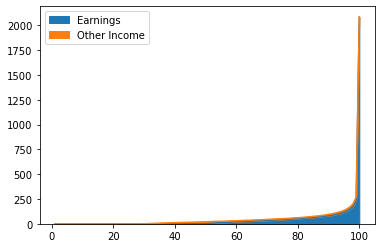

In [9]:
df = pd.DataFrame([s, s2, s-s2]).T
df.columns = ['Total Income', 'Earnings', 'Other Income']
df.index = df.index * 100.0
df.to_csv('/home/brian/Documents/uschartbook/chartbook/data/pearn_dist.csv', index_label='percentile')
df[['Earnings', 'Other Income']].plot(kind='area');

In [10]:
df[df['Total Income'] > 0]

,Total Income,Earnings,Other Income
28.0,0.001,0.000,0.001
29.0,0.024,0.000,0.024
30.0,0.500,0.000,0.500
31.0,1.500,0.000,1.500
32.0,2.660,0.000,2.660
...,...,...,...
96.0,150.241,129.000,21.241
97.0,170.803,150.000,20.803
98.0,202.010,175.000,27.010
99.0,270.350,240.000,30.350


In [19]:
df.loc[28:]

,Total Income,Earnings,Other Income
28.0,0.001,0.0,0.001
29.0,0.024,0.0,0.024
30.0,0.500,0.0,0.500
31.0,1.500,0.0,1.500
32.0,2.660,0.0,2.660
...,...,...,...
96.0,100.000,100.0,0.000
97.0,100.000,100.0,0.000
98.0,100.000,100.0,0.000
99.0,100.000,100.0,0.000
